In [1]:
%load_ext autoreload

In [30]:
%autoreload 2
import matplotlib.pyplot as plt
from nolds import corr_dim
import numpy as np
from scipy.spatial.distance import cdist
import sys
from tqdm.auto import tqdm

sys.path.append('/home/eisenaj/code/DeLASE/demo')
from demo_utils import D_PR

sys.path.append('/home/eisenaj/code/CommunicationJacobians')
from CommunicationJacobians.dysts_sim.flows import RNNChaotic, Lorenz
from CommunicationJacobians.dysts_sim.utils import compute_lyaps

In [11]:
def participation_ratio(traj):
    # traj is time x dim
    C_mat = traj.T @ traj
    eigvals = np.linalg.eigvals(C_mat)
    eigvals = eigvals.real
    return np.sum(eigvals)**2/np.sum(eigvals**2)
    # eigvals = eigvals / np.sum(eigvals)
    # return -np.sum(eigvals * np.log(eigvals))


In [40]:
def grassberger_procaccia(time_series, emb_dim, time_delay, plot=False):
    N = len(time_series)
    count = 0
    r_vals = np.logspace(-3, 0, num=20)  # Range of distances
    C_r = np.zeros(len(r_vals))

    # Create embedded vectors
    embedded_vectors = np.array([time_series[i:i+emb_dim*time_delay:time_delay] for i in range(N - (emb_dim-1)*time_delay)])
    
    for i in range(len(embedded_vectors)):
        for j in range(i + 1, len(embedded_vectors)):
            distance = np.linalg.norm(embedded_vectors[i] - embedded_vectors[j])
            C_r += (distance < r_vals)

    C_r /= (len(embedded_vectors) * (len(embedded_vectors) - 1) / 2)
    
    if plot:
        plt.loglog(r_vals, C_r, 'o-')
        plt.xlabel('log(r)')
        plt.ylabel('log(C(r))')
        plt.title('Correlation Sum vs. Distance')
        plt.show()
    
    # Linear fit to log-log plot to find slope (correlation dimension)
    log_r = np.log(r_vals)
    log_C_r = np.log(C_r)
    slope, _ = np.polyfit(log_r[1:-1], log_C_r[1:-1], 1)
    
    return slope


In [35]:
eq = Lorenz()
noise = 0
trajs = eq.make_trajectory(num_ics=3, n_periods=36, pts_per_period=100, noise=noise)

In [39]:
corr_dim(trajs[0, :, 0], emb_dim=8, lag=20)


np.float64(1.6617605588557158)

In [18]:
participation_ratio(trajs.reshape(-1, trajs.shape[-1]))

np.float64(1.4418465790186679)

In [29]:
participation_ratios = []
for pt_traj in trajs:
    dist_matrix = cdist(pt_traj, pt_traj)
    r = np.std(dist_matrix)*20
    participation_ratios.append(D_PR(pt_traj, r, dist_matrix=dist_matrix, verbose=False))
participation_ratios


[np.float64(1.9839597734195968),
 np.float64(1.9673924910970497),
 np.float64(1.973588982202312)]

In [62]:
# eq = RNNChaotic()
# W = eq.W
# trajs = {}
# noise = 0
# # for scale in tqdm([0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]):
# for scale in tqdm([0.7, 0.725, 0.75, 0.76, 0.77, 0.775, 0.78, 0.79, 0.8, 0.81, 0.82, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1]):
#     eq = RNNChaotic(W=W*scale, random_state=42)
#     trajs[scale] = eq.make_trajectory(num_ics=3, n_periods=12, pts_per_period=100, noise=noise)

  0%|          | 0/19 [00:00<?, ?it/s]

In [63]:
participation_ratios = {}
for scale, pts in tqdm(trajs.items()): 
    participation_ratios[scale] = []
    for pt_traj in pts:
        dist_matrix = cdist(pt_traj, pt_traj)
        r = np.std(dist_matrix)
        participation_ratios[scale].append(D_PR(pt_traj, r, dist_matrix=dist_matrix, verbose=False))
    # pts = pts.reshape(-1, pts.shape[-1])
    # dist_matrix = cdist(pts, pts)
    # r = np.std(dist_matrix)
    # participation_ratios[scale] = D_PR(pts, r, dist_matrix=dist_matrix, verbose=False)

  0%|          | 0/19 [00:00<?, ?it/s]

<ErrorbarContainer object of 3 artists>

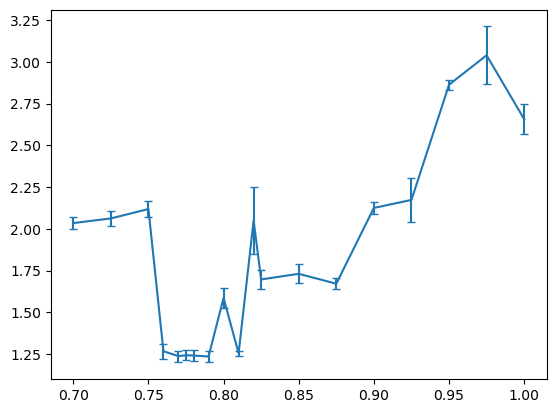

In [65]:
means = [np.mean(ratios) for ratios in participation_ratios.values()]
stds = [np.std(ratios)/np.sqrt(len(ratios)) for ratios in participation_ratios.values()]
scales = list(participation_ratios.keys())
plt.errorbar(scales, means, yerr=stds, capsize=3)

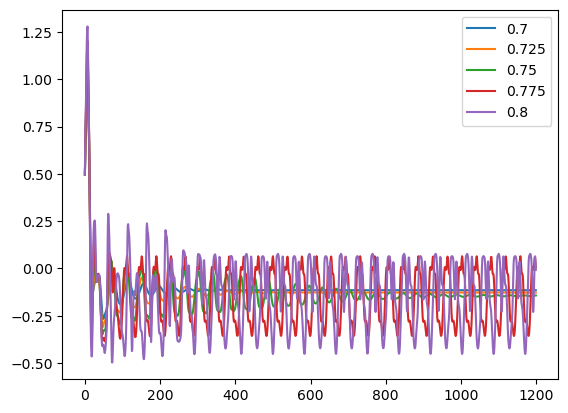

In [52]:
for scale, pts in trajs.items():
    if scale <= 0.8:

        plt.plot(pts[0, :, 0], label=f"{scale}")
plt.legend()